In [1]:
import os
import time
from math import sqrt
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from sklearn.externals import joblib
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


#### 导入预处理过后的数据集

In [2]:
def import_dataset():
    
    # today_string = datetime.datetime.today().strftime('%Y_%m_%d')
    # df = pd.read_csv('open_data_pre_2020_06_10.csv')
    
    global today_string
    today_string = datetime.datetime.today().strftime('%Y_%m_%d')
    filename = 'wentai_data_pre/wentai_data_' + today_string + '.csv'
    df = pd.read_csv(filename)
    df['时间'] = pd.to_datetime(df['时间'])
    df= df.set_index('时间')
    df = df.astype(float)

    return df

#### 时间序列数据转化为监督学习

In [3]:
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
    """
    将时间序列重构为监督学习数据集.
    参数:
        data: 观测值序列，类型为列表或Numpy数组。
        n_in: 输入的滞后观测值(X)长度。
        n_out: 输出观测值(y)的长度。
        dropnan: 是否丢弃含有NaN值的行，类型为布尔值。
    返回值:
        经过重组后的Pandas DataFrame序列.
    """
    n_vars = 1 if type(df) is list else df.shape[1]
#     df = DataFrame(data)
    cols, names = list(), list()
    # 输入序列 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(df.columns[j]+'_t-%d' % (i)) for j in range(n_vars)]
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(df.columns[j]+'_t') for j in range(n_vars)]
        else:
            names += [(df.columns[j]+'_t+%d' % i) for j in range(n_vars)]
    # 将列名和数据拼接在一起
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 丢弃含有NaN值的行
    agg.dropna(inplace=True)
    return agg

#### 我们需要是稳态阶段的数据，所以数据应该是取自每次生产开始到关机前，所有满足[30°±2°，70%±5%] 这个范围内的数据。

In [4]:
def data_selected(T_standard_min = 28,T_standard_max = 32,H_standard_min = 65,H_standard_max = 75):

    # 先找到每次生产的开关机时间点
    df_concat_weather = import_dataset()

    df_data_open = df_concat_weather[df_concat_weather['送风机电流'].diff() > 20]
    df_data_close = df_concat_weather[df_concat_weather['送风机电流'].diff() < -30]

    # 这里能看到有开机和关机时间间隔很短的情况，所以这种开机的时间我们需要拿掉。
    ## 假设我们设定的判断标准是开机和关机时间必须要间隔8小时以上，否则视为无效开机。

    df_data_open_select_index =[]
    df_data_close_select_index =[]
    df_data_close_select_index.append(df_data_close.index[0])
    for i in (df_data_close.index[1:]):
        mask = (i - (df_data_open.index[df_data_open.index < i][-1])) > pd.Timedelta(hours=8)
        if mask:
            df_data_open_select_index.append(df_data_open.index[df_data_open.index < i][-1])
            df_data_close_select_index.append(i)

    # 选取稳态阶段符合工艺标准的数据
    data_wentai=[]
    data_select_append=[]

    for i in range(len(df_data_open_select_index)):
        # 选取开机以后第一次
        df_select = df_concat_weather[(df_concat_weather.index >= df_data_open_select_index[i]) & (df_concat_weather.index <= df_data_close_select_index[1:][i])]
        # 需要找到基于稳态阶段,稳态阶段应为每次开机以后,在设定的温湿度标准范围内的数据记录。
        df_select = df_select[(df_concat_weather['TAT7205-1T'] >= T_standard_min) &
                              (df_concat_weather['TAT7205-1T'] <= T_standard_max) &
                              (df_concat_weather['TAT7205-2T'] >= T_standard_min) &
                              (df_concat_weather['TAT7205-2T'] <= T_standard_max) &
                              (df_concat_weather['TAT7205-3T'] >= T_standard_min) &
                              (df_concat_weather['TAT7205-3T'] <= T_standard_max) &
                              (df_concat_weather['TAT7205-4T'] >= T_standard_min) &
                              (df_concat_weather['TAT7205-4T'] <= T_standard_max) &
                              (df_concat_weather['TAT7205-5T'] >= T_standard_min) &
                              (df_concat_weather['TAT7205-5T'] <= T_standard_max) &
                              (df_concat_weather['TAT7205-1H'] >= H_standard_min) &
                              (df_concat_weather['TAT7205-1H'] <= H_standard_max) &
                              (df_concat_weather['TAT7205-2H'] >= H_standard_min) &
                              (df_concat_weather['TAT7205-2H'] <= H_standard_max) &
                              (df_concat_weather['TAT7205-3H'] >= H_standard_min) &
                              (df_concat_weather['TAT7205-3H'] <= H_standard_max) &
                              (df_concat_weather['TAT7205-4H'] >= H_standard_min) &
                              (df_concat_weather['TAT7205-4H'] <= H_standard_max) &
                              (df_concat_weather['TAT7205-5H'] >= H_standard_min) &
                              (df_concat_weather['TAT7205-5H'] <= H_standard_max)]

        data_select_append.append(df_select)
        df_select_append = pd.concat(data_select_append)

        # 把时间序列重构为监督学习维度
        # 在这里，我们想要用前一和当前时间步的结果去预测未来一次的结果
        df_select_time_series = series_to_supervised(df_select,n_in=1, n_out=2, dropnan=True)

        data_wentai.append(df_select_time_series)
        df_wentai = pd.concat(data_wentai)


    # df_wentai.filter(like='t+1').columns

    # 对于t+1时刻，我们只需要预测5个阀门的开度组合，以及送风的温湿度值，需要拿掉(t+1)时刻不需要的维度:
    drop_columns = ['TAT7205-1T_t+1', 'TAT7205-1H_t+1','TAT7205-2T_t+1', 'TAT7205-2H_t+1', 'TAT7205-3T_t+1', 'TAT7205-3H_t+1',
                    'TAT7205-4T_t+1', 'TAT7205-4H_t+1', 'TAT7205-5T_t+1', 'TAT7205-5H_t+1','回风湿度_t+1', '新风温度_t+1', 
                    '新风湿度_t+1', '送风机电流_t+1', '回风温度_t+1','九千RCC入口水分实际值_t+1', '九千RCC入口烟叶流量_t+1', 
                    '九千RCC入口烟叶流量累计值_t+1', '九千烘丝烟叶温度随机值_t+1',
                    '三千烘丝入口水分实际值_t+1', '三千烘丝入口烟叶流量_t+1', '三千烘丝入口烟叶流量累计值_t+1',
                    '九千加料出口水分实际值_t+1', '九千加料出口温度实际值_t+1', '九千加料烟叶流量实际值_t+1',
                    '九千加料烟叶流量累计值_t+1', '五千加料出口水分实际值_t+1', '五千加料出口温度实际值_t+1',
                    '五千加料烟叶流量实际值_t+1', '五千加料烟叶流量累计值_t+1', '五千烘丝入口水分实际值_t+1',
                    '五千烘丝入口烟叶流量_t+1', '五千烘丝入口烟叶流量累计值_t+1', '三千加料烟叶流量实际值_t+1',
                    '三千加料出口温度实际值_t+1', '三千烘丝烟叶温度随机值_t+1', '五千烘丝烟叶温度随机值_t+1',
                    '天气预报温度_t+1', '天气预报湿度_t+1']
    df_wentai.drop(drop_columns,axis=1, inplace=True)

    return df_wentai, df_select_append

#### 数据特征可视化

In [5]:
def data_selected_info_print():
    df_wentai, df_select_append = data_selected()
    print('输入数据维度: {} '.format(df_select_append.columns))
    print('最小日期为: {} '.format(df_wentai.index.min()))
    print('最大日期为: {} '.format(df_wentai.index.max()))
    print('数据量为: {} '.format(df_wentai.shape[0]))
    print('数据维度为: {} '.format(df_wentai.shape[1]))      

In [6]:
def feature_plots():
    %matplotlib inline
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    df_wentai, df_select_append = data_selected()

    fig, axes = plt.subplots(len(df_select_append.columns), 1, figsize=(15,220), constrained_layout=True)

    for group in range(len(df_select_append.columns)):
    #     axes[group].plot(values[:, group])
        axes[group].plot(df_select_append[df_select_append.columns[group]], 'o', alpha=0.1)
        axes[group].set(xlabel='Time')
        axes[group].set(ylabel='values')
        axes[group].set_title(df_select_append.columns[group])

        ax = axes.flatten()[group]  

        # Define the date format
        date_form = DateFormatter("%m-%d")
        ax.xaxis.set_major_formatter(date_form)

        # Ensure a major tick for each week using (interval=1) 
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    
    fig.savefig('feature_plots.png')
    plt.show()

#### 分割为训练集和测试集

In [7]:
# 分为输入输出
def scaled_X_y(daysToTrain=45):
    
    # 将选取前N天的数据作为训练集，之后的数据作为测试集
    n_train_mins_steps = int(daysToTrain*24*60/2)

    # hours=2
    # features=46

    # train = scaled[:n_train_mins_steps, :]
    # test = scaled[n_train_mins_steps:, :]

    # train_X, train_y = train[:, :-9], train[:, -9:-2]
    # test_X, test_y = test[:, :-9], test[:, -9:-2]
    
    # 分离为训练和测试集，暂不考虑下一时间步的天气
    df_wentai, df_select_append = data_selected()

    # 分离为训练和测试集，暂不考虑下一时间步的天气
    train = df_wentai.iloc[:n_train_mins_steps, :]
    test = df_wentai.iloc[n_train_mins_steps:, :]

    # 归一化特征
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit(train)

    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)

    train_X, train_y = train_scaled[:, :-7], train_scaled[:,-7:]
    test_X, test_y = test_scaled[:, :-7], test_scaled[:, -7:]

    # 重塑成3D形状 [样例, 时间步, 特征]
    train_X_3D = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_3D = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#     print(train_X_3D.shape, train_y.shape, test_X_3D.shape, test_y.shape)

    return train_X_3D, train_y, test_X_3D, test_y, scaler, train_X, test_X

In [8]:
# 找出时间步不是2分钟的数据
# index_drop = (df_wentai.reset_index()[df_wentai.reset_index()['时间'].diff() != pd.Timedelta(minutes=2)]).index

In [9]:
# 设计LSTM网络
def model_lstm(train_X, train_y, test_X, test_y, neurons, epochs, batch_size):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(7))
    model.compile(loss='mae', optimizer='adam')

    # 拟合网络
    history = model.fit(train_X, train_y, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)
    
    #绘制历史数据拟合情况
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    
    plt.savefig('model_performance.png')
    plt.show()

    return model

In [10]:
# 模型预测
def model_pred(model,scaler,test_X_3D,test_X, test_y):
    
    yhat = model.predict(test_X_3D)
#     test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # 反向转换预测值比例
    inv_yhat = np.concatenate((test_X, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    
    # 反向转换实际值比例
    # test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    
    return inv_yhat, inv_y 

In [11]:
# 模型评估
def th_model_performance(inv_yhat, inv_y):
    
    rmse_t = sqrt(mean_squared_error(inv_y[:,-2], inv_yhat[:,-2]))
    r2_t = r2_score(inv_y[:,-2], inv_yhat[:,-2])
    print('送风温度预测 RMSE: %.3f' % rmse_t)
    print('送风温度预测 R2: %.3f' % r2_t)

    rmse_h = sqrt(mean_squared_error(inv_y[:,-1], inv_yhat[:,-1]))
    r2_h = r2_score(inv_y[:,-1], inv_yhat[:,-1])
    print('送风湿度预测 RMSE: %.3f' % rmse_h)
    print('送风湿度预测 R2: %.3f' % r2_h)

In [12]:
def prediction_plot(inv_yhat, inv_y):
    
    %matplotlib inline
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    df_wentai, df_select_append = data_selected()
    inv_yhat, inv_y= model_pred(model,scaler,test_X_3D,test_X, test_y)

    column_names = df_wentai[df_wentai.columns[-7:]].rename(columns = lambda x : str(x)[:-4]).columns

    fig, axes = plt.subplots(len(column_names), 1, figsize=(15, 40), constrained_layout=True)

    for i in range(len(column_names)):
        #     axes[group].plot(values[:, group])
        axes[i].plot(inv_yhat[:,-i-1], label=(column_names[-i-1]+'预测值'))
        axes[i].plot(inv_y[:,-i-1], label=(column_names[-i-1]+'实际值'))

        #         axes[group].set(xlabel='Time')
        axes[i].set(ylabel='values')
        axes[i].set_title(column_names[-i-1]+'预测对比折线图')
        axes[i].legend()
        ax = axes.flatten()[i]  

        # Define the date format
        date_form = DateFormatter("%m-%d")
        ax.xaxis.set_major_formatter(date_form)

        # Ensure a major tick for each week using (interval=1) 
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

        fig.savefig('prediction_plots.png')
        
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Train on 39600 samples, validate on 5519 samples
Epoch 1/100
 - 2s - loss: 0.1014 - val_loss: 0.0713
Epoch 2/100
 - 2s - loss: 0.0767 - val_loss: 0.0727
Epoch 3/100
 - 1s - loss: 0.0608 - val_loss: 0.0681
Epoch 4/100
 - 1s - loss: 0.0552 - val_loss: 0.0736
Epoch 5/100
 - 1s - loss: 0.0528 - val_loss: 0.0693
Epoch 6/100
 - 1s - loss: 0.0490 - val_loss: 0.0662
Epoch 7/100
 - 2s - loss: 0.0460 - val_loss: 0.0580
Epoch 8/100
 - 2s - loss: 0.0441 - val_loss: 0.0627
Epoch 9/100
 - 1s - loss: 0.0403 - val_loss: 0.0483
Epoch 10/100
 - 1s - loss: 0.0385 - val_loss: 0.0451
Epoch 11/100
 - 1s - loss: 0.0368 - val_loss: 0.0504
Epoch 12/100
 - 1s - loss: 0.0347 - val_loss: 0.0520
Epoch 13/100
 - 1s - loss: 0.0337 - val_loss: 0.0508
Epoch 14/100
 - 1s - loss: 0.0320 - val_loss: 0.0496
Epoch 15/100
 - 1s - loss: 0.0309 - val_loss: 0.0376
Epoch 16/100
 - 1s - loss: 0.0308 - val_loss: 0.0481
Epoch 17/100
 - 1s - loss: 0.0283 - val_loss: 0.0433
Epoch 18/100
 - 2s - loss: 0.0273 - val_loss: 0.0372
Epoch

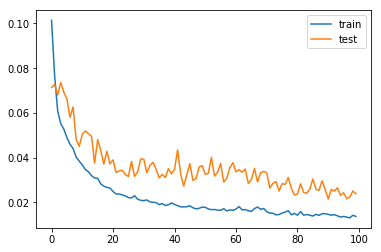

送风温度预测 RMSE: 0.264
送风温度预测 R2: 0.890
送风湿度预测 RMSE: 0.991
送风湿度预测 R2: 0.897


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


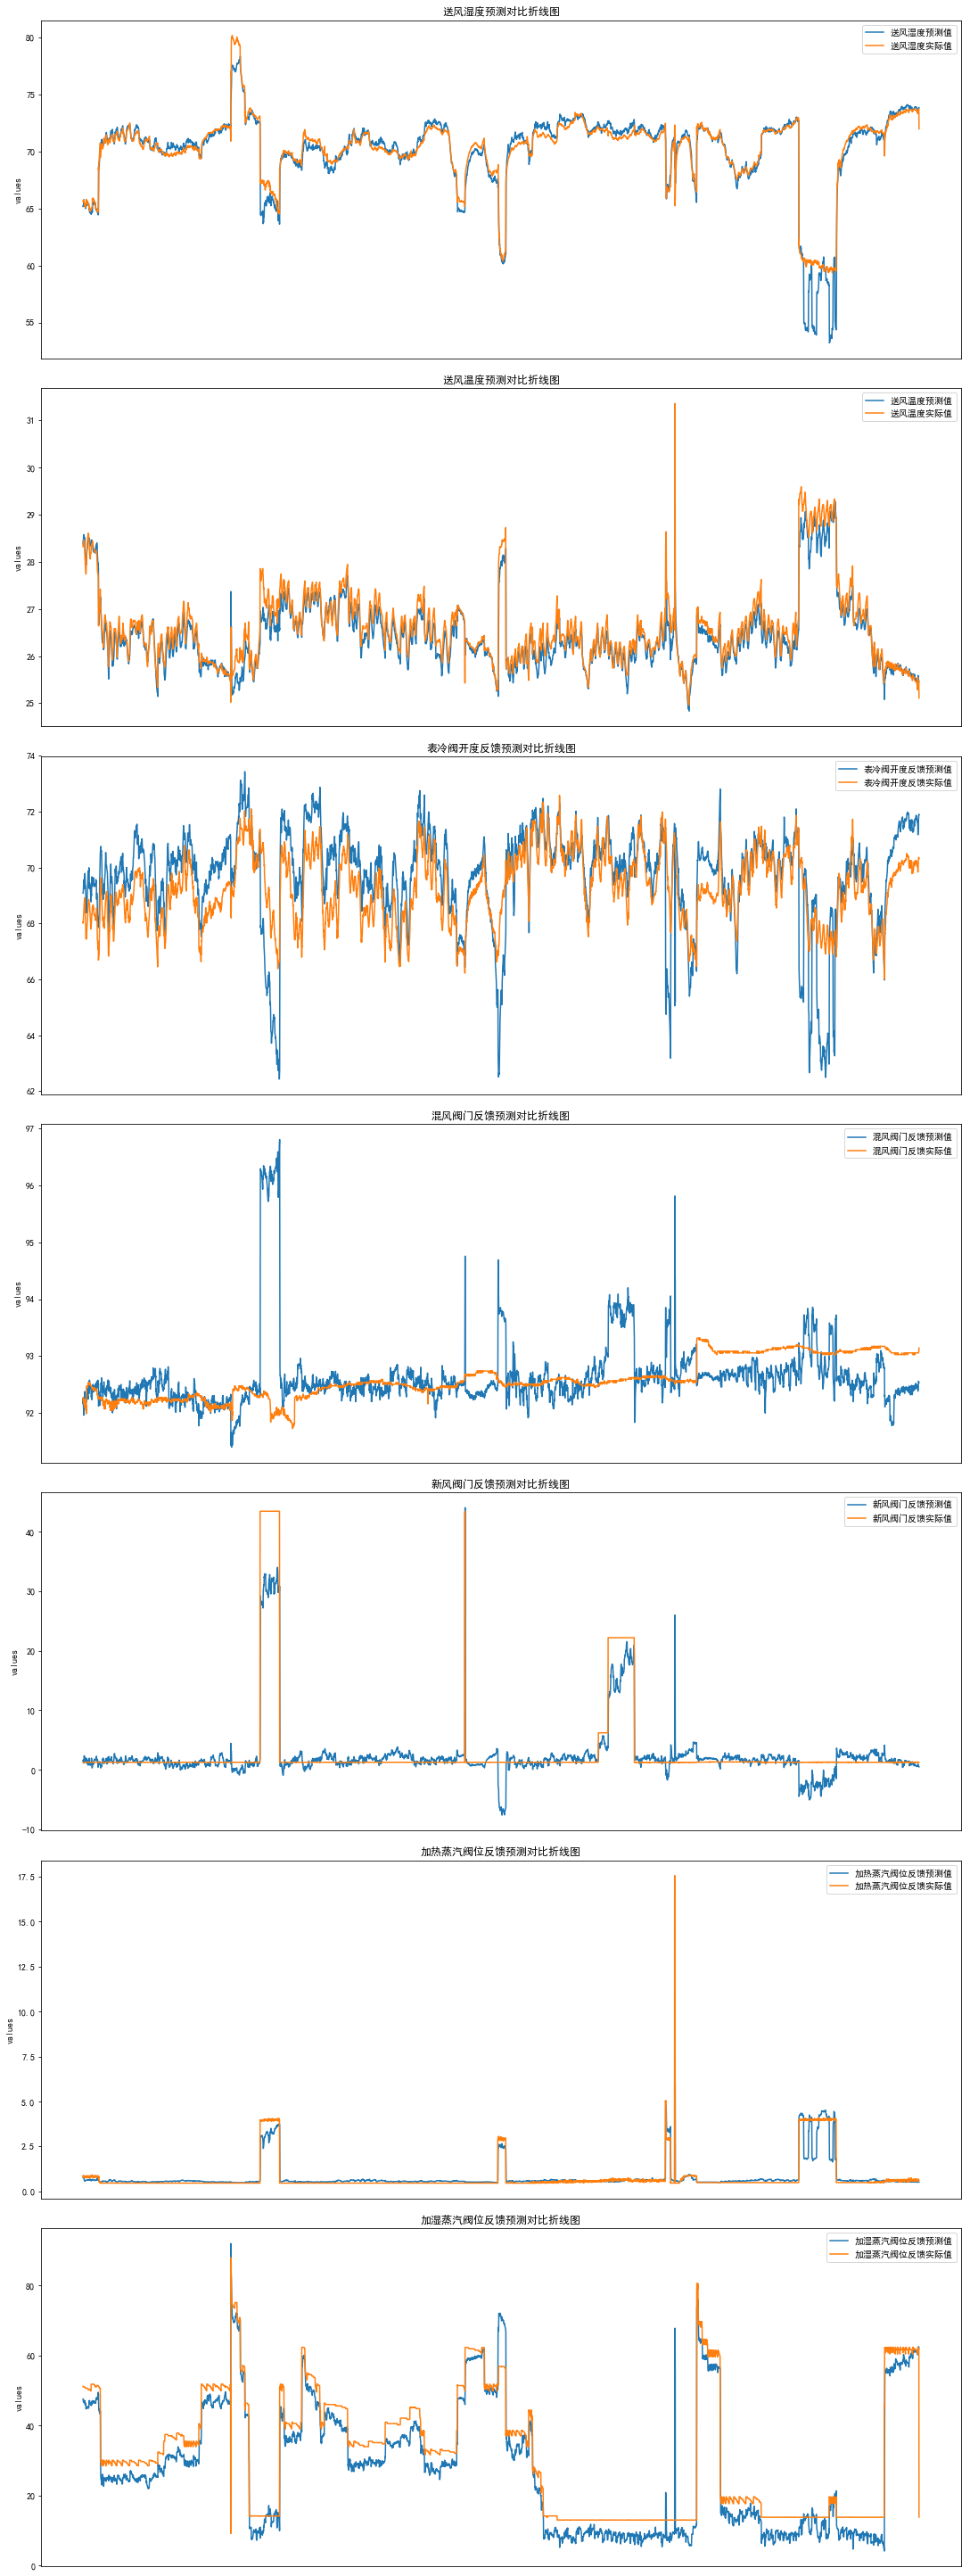

训练模型已经保存到本地
Running time: 181.502932 Seconds


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [13]:
if __name__=="__main__":

    start =time.clock()
    
    #定义训练数据的量级
    daysToTrain=55
    
    #定义LSTM模型训练的入参：
    neurons = 50
    epoches = 100
    batch_size = 72
    
    train_X_3D, train_y, test_X_3D, test_y, scaler, train_X, test_X = scaled_X_y(daysToTrain)
    
     # Save the scaler
    scaler_file = "model/wentai_HT_scaler.save"
    joblib.dump(scaler, scaler_file) 
    
    #训练模型
    model = model_lstm(train_X_3D, train_y, test_X_3D, test_y, neurons, epoches, batch_size)
    
    #模型预测
    inv_yhat, inv_y= model_pred(model,scaler,test_X_3D,test_X,test_y)
    
    #模型评估
    th_model_performance(inv_yhat, inv_y)
    
    #模型预测可视化
    prediction_plot(inv_yhat, inv_y)
    
    #储存模型
    dump(model, 'model/wentai_lstm_'+ today_string + '.joblib') 
    
    
    print('训练模型已经保存到本地')
    end = time.clock()
    
    print('Running time: %s Seconds'%(end-start))